In [0]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf

In [146]:
#获取数据
mnist = input_data.read_data_sets("/temp/data",one_hot=True)

Extracting /temp/data/train-images-idx3-ubyte.gz
Extracting /temp/data/train-labels-idx1-ubyte.gz
Extracting /temp/data/t10k-images-idx3-ubyte.gz
Extracting /temp/data/t10k-labels-idx1-ubyte.gz


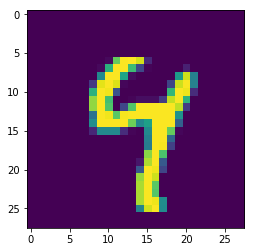

In [147]:
#输出图片2
mnist_two = mnist.train.images[2,:].reshape(28,28)
plt.imshow(mnist_two)
plt.show()

在开始运行前，请先搞懂CNN
[CNN工作原理](https://www.evernote.com/shard/s725/sh/8278bf2c-1942-43f2-a77c-f5f841c38a0b/501b1ab5bda2032253c93cbc11f1f55e)

In [0]:
#池化操作(w是一个CNN的过滤器),填充选0填充
#conv2d 的参数 x，是一个 4 维张量，每一个维度分别代表 batch,in_height,in_height,in_channels
#conv2d的参数filter [filter_height, filter_width, in_channels,out_channels]
def conv2d(x,w,b,strides=1):
  con = tf.nn.conv2d(x,w,[1,strides,strides,1],padding='SAME')
  con = tf.nn.bias_add(con,b)
  #选择relu激活
  return tf.nn.relu(con)

#池化层封装
#tf.nn.max_pool(x, ksize, strides ,padding)
#ksize是卷积核的大小，是一个四维张量
def maxpool(x,k=2):
  return tf.nn.max_pool(x,[1,k,k,1],[1,k,k,1],padding='SAME')

[tf.nn.conv2d()函数解释](https://www.evernote.com/shard/s725/sh/6dbbbba2-bf44-4386-92c1-7821b960a928/fc97045eda5d36c70968e50b13c7367c)




In [0]:
#超参数设置
#训练参数
learning_rate = 0.02
batch_size = 128
steps = 200
show_steps = 10
#每个批次的大小
batch_size =100
num_batch = mnist.train.num_examples // batch_size

#网络参数
num_inputs =784
num_classes = 10
#神经元保留率
dropout = 0.75

![tensorflow网络结构](http://www.tensorflownews.com/wp-content/uploads/2018/03/5-14.png)

In [0]:
def conv_net(x,weights,biases,dropout):
  x = tf.reshape(x,shape=[-1,28,28,1])
  
  #每次卷积都加了relu层！！！！
  #卷积后大小：（rawH-filterH+1）=ConvH
  #池化后大小 rawH*rawH/(ksize*ksize)
  #输出通道类似神经元
  
  #第一层卷积
  #此层卷积核利用[5,5,1,32] 利用填充后变为32*32 |卷积后大小：（32-5+1）=28 | 卷积之后变为28*28 输出通道数32
  con1 = conv2d(x,weights['wc1'],biases['bc1'])
  #第一层池化
   #经过池化核2*2，池化之后为14*14 输出通道数32
  con1 = maxpool(con1,k=2)
  
  #第二层卷积
  #此层卷积核利用[5,5,32,64] 利用填充后变为18*18 |卷积后大小：（18-5+1）=14 | 卷积之后变为14*14 输出通道数64
  con2 = conv2d(con1,weights['wc2'],biases['bc2'])
  #第二层池化
  #经过池化核2*2，池化之后为7*7 输出通道数64
  con2  = maxpool(con2,k=2)
  
  #全连接层
  #把fc1拉成一维张量
  fc1 = tf.reshape(con2,shape=[-1,weights['wd1'].get_shape().as_list()[0]])
  #使fc1通过weight[7*7*64,1024] 变为1024个神经元
  fc1 = tf.add(tf.matmul(fc1,weights['wd1']),biases['bd1'])
  fc1 = tf.nn.relu(fc1)
  #丢弃
  fc1 = tf.nn.dropout(fc1,dropout)
  
  #输出层
  #使输出为10个神经元
  out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
  return out

In [0]:
#初始化函数
def weight_variable(shape):
  #初始化权值参数时，使用了tf.truncated_normal函数，该函数的原型是 tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)。
  #函数的输出是一个tensor，其形状是由输入参数shape进行定义，tensor中的值满足截断正态分布，
  #值的数据类型默认是tf.float32。weight_variable([5, 5, 1, 32])则返回5*5*1*32的tensor变量。
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


#tf的变量添加
X = tf.placeholder(tf.float32,[None,num_inputs])
Y = tf.placeholder(tf.float32,[None,num_classes])




weights = {
'wc1': weight_variable([5,5,1,32]),
'wc2': weight_variable([5,5,32,64]),
'wd1': weight_variable([7*7*64,1024]),
'out': weight_variable([1024, 10])
}
biases = {
'bc1': bias_variable([32]),
'bc2': bias_variable([64]),
'bd1': bias_variable([1024]),
'out': bias_variable([10])
}


In [0]:
#效果评估

#softmax10分类
out = conv_net(X,weights,biases,dropout)
prediction = tf.nn.softmax(out)

#构造训练模型
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=prediction, labels=Y))
train = tf.train.AdamOptimizer(1e-4).minimize(loss)

#计算准确率
pred_acc = tf.equal(tf.argmax(prediction,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(pred_acc,tf.float32))

In [153]:
#训练
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(steps+1):
    for batch in range(num_batch):
      batch_x, batch_y = mnist.train.next_batch(batch_size)
      sess.run(train,feed_dict={X:batch_x,Y:batch_y})
    if step % show_steps ==0:
      acc = sess.run(accuracy,feed_dict={X:mnist.test.images,Y:mnist.test.labels})
      print(str(step)+":accuracy=%.3f" %acc)

0:accuracy=0.852
10:accuracy=0.984
20:accuracy=0.990
30:accuracy=0.990
40:accuracy=0.991
50:accuracy=0.991
60:accuracy=0.992
70:accuracy=0.992
80:accuracy=0.993
90:accuracy=0.991
100:accuracy=0.993
110:accuracy=0.992
120:accuracy=0.992
130:accuracy=0.992
140:accuracy=0.992
150:accuracy=0.992
160:accuracy=0.993
170:accuracy=0.991
180:accuracy=0.993
190:accuracy=0.990
200:accuracy=0.992
